In [37]:
%%capture --no-stderr
%pip install -U langchain_core langchain_community langchain-ollama

In [38]:
%%capture --no-stderr
%pip install langfuse langchain --upgrade

In [3]:
import os, getpass

def _set_env(var: str):
    os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGFUSE_PUBLIC_KEY")
_set_env("LANGFUSE_SECRET_KEY")

LANGFUSE_PUBLIC_KEY:  ········
LANGFUSE_SECRET_KEY:  ········


In [5]:
from langfuse import Langfuse
from langfuse.callback import CallbackHandler

# Initialize Langfuse client
langfuse = Langfuse(
    public_key=os.getenv("LANGFUSE_PUBLIC_KEY"),
    secret_key=os.getenv("LANGFUSE_SECRET_KEY"),
    host="http://localhost:3000"
)

langfuse_handler = CallbackHandler(
    public_key=os.getenv("LANGFUSE_PUBLIC_KEY"),
    secret_key=os.getenv("LANGFUSE_SECRET_KEY"),
    host="http://localhost:3000"
)


In [6]:
# Optional, verify that Langfuse is configured correctly
assert langfuse.auth_check()
assert langfuse_handler.auth_check()

## Scoring responses

Here we will take a look at Scoring with LLM as a judge

In [7]:
langfuse.create_prompt(
    name="llm-evaluator",
    prompt=
    """You are an expert professor specialized in grading students' answers to questions.
    You are grading the following question:
    {{query}}
    Here is the real answer:
    {{answer}}
    You are grading the following predicted answer:
    {{result}}
    Respond with CORRECT or INCORRECT:
    Grade:
    """,
    config={
        "model":"llama3.1",
        "temperature": 0,
    },
    labels=["evaluation"]
)

In [8]:
eval_prompt_from_langfuse = langfuse.get_prompt("llm-evaluator", label=["evaluation"], cache_ttl_seconds=0)

In [9]:
eval_prompt_from_langfuse.get_langchain_prompt()

"You are an expert professor specialized in grading students' answers to questions.\n    You are grading the following question:\n    {query}\n    Here is the real answer:\n    {answer}\n    You are grading the following predicted answer:\n    {result}\n    Respond with CORRECT or INCORRECT:\n    Grade:\n    "

In [10]:
eval_prompt = eval_prompt_from_langfuse.get_langchain_prompt()

In [11]:
from langchain_core.prompts.prompt import PromptTemplate
from langchain_ollama import ChatOllama

model = 'llama3.1'
temperature=0

EVAL_PROMPT = PromptTemplate(
    input_variables=["query", "answer", "result"], 
    template=eval_prompt,
    metadata={"langfuse_prompt": eval_prompt_from_langfuse}
)

# We should use an advanced LLM as evaluator, use this only for testing/learning purposes
eval_llama = ChatOllama(
    model=model,
    temperature=temperature
)

eval_chain = EVAL_PROMPT | eval_llama

In [12]:
traces = langfuse.fetch_traces()

In [13]:
len(traces.data)

1

In [14]:
last_trace = traces.data[-1] # Last trace

In [15]:
last_trace_input = last_trace.input
last_trace_result = last_trace.output["content"]

In [16]:
last_trace_result

"**Wedding Event Plan: Julia and Alex's Special Day**\n\n**Event Concept:** A whimsical and romantic celebration of love, art, and nature, blending traditional and contemporary elements to reflect the couple's unique personalities.\n\n**Date:** June 5, 2024\n**Time:** 3:00 pm - 10:00 pm (ceremony at 3:00 pm, cocktail hour at 4:30 pm, dinner at 6:00 pm)\n**Location:** Central Park, New York City\n\n**Audience:**\n\n* Guests: 150 close friends and family members\n* Age range: 25-60 years old\n* Interests: Art, nature, music, food, and celebration of love\n\n**Budget:** $75,000 (inclusive of all expenses)\n\n**Venue:**\n\n* **Central Park**: The picturesque park will serve as the backdrop for the ceremony, cocktail hour, and dinner. A private area within the park has been reserved for the event.\n* **Tented Structure**: A custom-designed tent with a natural, earthy aesthetic will be set up to accommodate the ceremony, cocktail hour, and dinner.\n\n**Catering Options:**\n\n* **Food**: A se

In [17]:
def trace_score(query, result):
    response = eval_chain.invoke(
        {
            "query": query,
            # These results are gathered from GPT4, this is wrong, this should be manually setup
            # This should be the "real answer"
            "answer": """Event Title: The Wedding of Julia and Alex

                        Event Date: June 5, 2024
                        
                        Venue: Central Park, New York City
                        
                        Event Description: The wedding of Julia and Alex will be a beautiful celebration of their love, combining their passion for art and nature. This event will blend traditional and contemporary elements to reflect the unique personalities of the couple. Set in the picturesque Central Park, the wedding will offer a serene and romantic backdrop, perfect for such a joyous occasion.
                        
                        Audience: The expected audience will include family members, close friends, and colleagues of Julia and Alex, totaling around 150 guests. The guest list will comprise people who appreciate art and nature, and who have been significant in the couple’s journey.
                        
                        Budget: The total budget for the wedding is estimated to be around $50,000. This will cover venue, catering, entertainment, decorations, photography, and other miscellaneous expenses.
                        
                        Venue Details: The ceremony will take place at the Central Park Conservatory Garden, which offers a stunning and private space with lush greenery and beautiful floral arrangements. The reception will follow at the nearby Loeb Boathouse, which provides an elegant setting by the lake.
                        
                        Catering Options:
                        
                        Great Performances: Known for their focus on sustainable and locally sourced ingredients, they will provide a customized menu that includes vegetarian and vegan options, reflecting the couple’s dietary preferences.
                        Union Square Events: Offering a farm-to-table experience, they will create a menu that highlights seasonal ingredients, complementing the natural setting of Central Park.
                        Entertainment:
                        
                        Live Band: A local jazz band will perform during the reception, providing a lively and sophisticated atmosphere.
                        DJ: Post-live band, a DJ will take over to play a mix of contemporary hits and classic favorites, ensuring the dance floor stays energetic.
                        Art Installations: Interactive art installations by local artists will be set up around the reception area, allowing guests to engage with and appreciate art in various forms.
                        Decorations:
                        
                        Floral Arrangements: Emphasizing greenery and wildflowers, the floral decorations will be handled by a local florist specializing in organic and natural designs.
                        Lighting: Soft, ambient lighting will be arranged to complement the natural sunset, with fairy lights and lanterns enhancing the romantic setting.
                        Photography:
                        
                        Alex Knight Photography: Specializing in natural light photography, they will capture the essence of the day, focusing on candid moments and breathtaking landscapes.
                        Logistics:
                        
                        Permits: Necessary permits for hosting the event in Central Park will be secured well in advance.
                        Transportation: Shuttle services will be arranged for guests from designated parking areas to the venue.
                        Accommodations: A block of rooms will be reserved at a nearby hotel for out-of-town guests, ensuring convenience and comfort.
                        Weather Contingency: In case of inclement weather, tents and canopies will be set up to protect guests and ensure the event proceeds smoothly.
                        Timeline:
                        
                        4:00 PM: Ceremony at Central Park Conservatory Garden
                        5:00 PM: Cocktail hour with light refreshments and interactive art installations
                        6:00 PM: Reception at Loeb Boathouse, dinner served
                        7:30 PM: Speeches and toasts
                        8:00 PM: First dance followed by live band performance
                        10:00 PM: DJ takes over
                        12:00 AM: Event concludes""",
            "result": result
        },
        config={"callbacks":[langfuse_handler]}
    )
    return response.content

In [18]:
trace_score(query=last_trace_input, result=last_trace_result)

'Grade: CORRECT\n\nThe predicted answer accurately captures the essence of Julia and Alex\'s wedding event plan, including the date, location, audience, budget, venue details, catering options, entertainment, potential vendors, logistics, timeline, and budget breakdown. While there are some minor discrepancies in the specific details (e.g., time, vendor names), the overall structure and content of the predicted answer align with the real answer.\n\nThe predicted answer demonstrates a good understanding of the event\'s concept, target audience, and logistical requirements. It also shows attention to detail in terms of vendor selection, catering options, and budget allocation.\n\nHowever, there are some minor errors and omissions:\n\n* The time for the ceremony is listed as 3:00 pm, whereas the real answer specifies 4:00 PM.\n* The predicted answer does not mention the specific event name ("The Wedding of Julia and Alex") or the event description in detail.\n* Some vendor names and detai

As we can see there is a major issue, the LLM prints at a free style format all the evaluation results. Now Im looking for a numerical grade to allow me to comparate prompts, so our current prompt needs to be modified.

So lets iterate and create a new version of the prompt "llm-evaluator" that enforces the output in a XML format, with this we are following prompt versioning best practices

In [19]:
langfuse.create_prompt(
    name="llm-evaluator",
    prompt=
    """You are an expert professor specialized in grading students' answers to questions.
    You are grading the following question:
    {{query}}
    Here is the real answer:
    {{answer}}
    You are grading the following predicted answer:
    {{result}}
    Your goal is to score the student answer based on how close it is to the correct answer.
    This is a pass/fail test. If the two answers are basically the same, the score should be 100. 
    Minor things like punctuation, capitilization, or spelling should not impact the score.
    
    If the two answers are different, then the score should be 0.
    Please you your score in a 'score' XML tag, and any reasoning
    in a 'reason' XML tag.
    """,
    config={
        "model":"llama3.1",
        "temperature": 0,
    },
    labels=["evaluation"]
)

### How the new version should looks like:

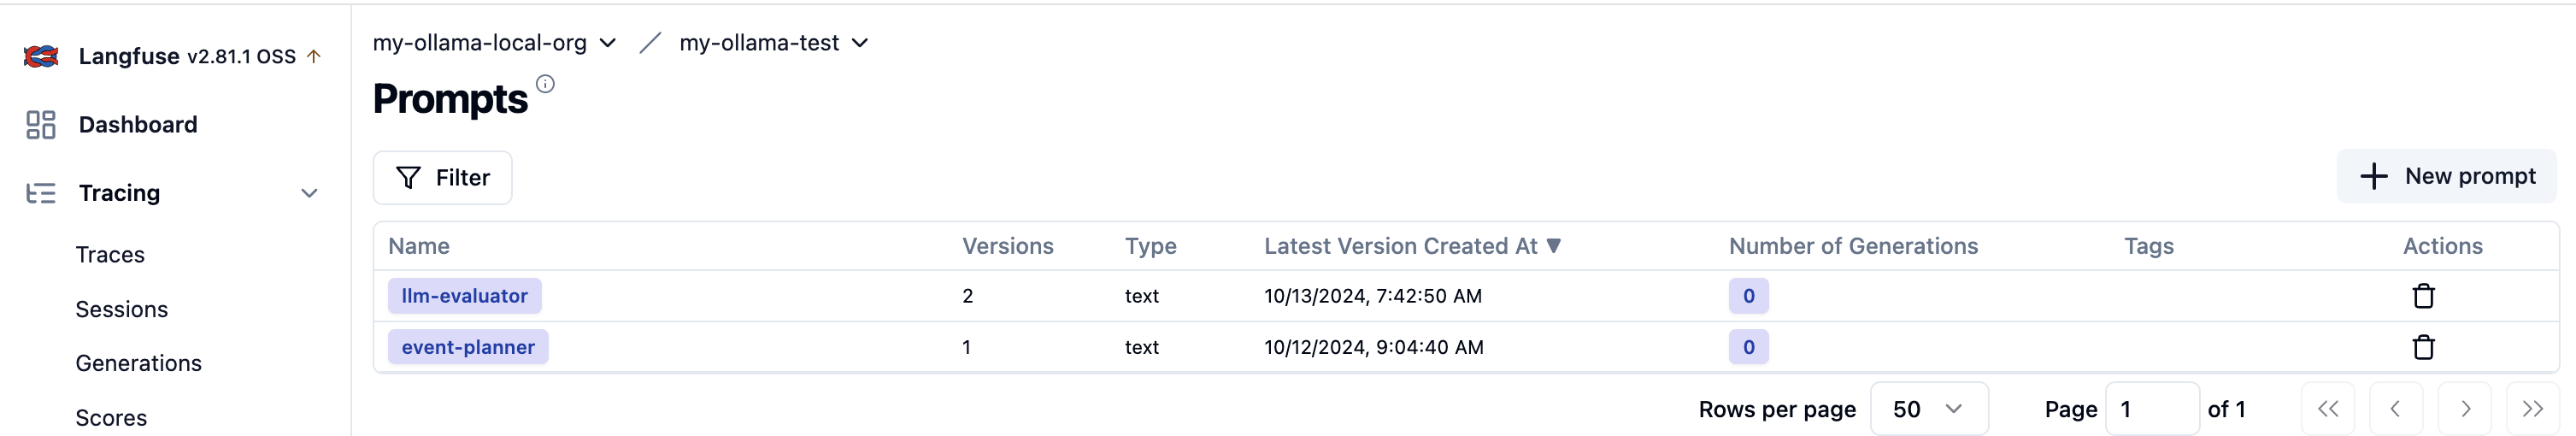

In [20]:
# These results are gathered from GPT4, this is wrong, this should be manually setup
real_answer = """
Event Title: The Wedding of Julia and Alex

Event Date: June 5, 2024

Venue: Central Park, New York City

Event Description: The wedding of Julia and Alex will be a beautiful celebration of their love, combining their passion for art and nature. This event will blend traditional and contemporary elements to reflect the unique personalities of the couple. Set in the picturesque Central Park, the wedding will offer a serene and romantic backdrop, perfect for such a joyous occasion.

Audience: The expected audience will include family members, close friends, and colleagues of Julia and Alex, totaling around 150 guests. The guest list will comprise people who appreciate art and nature, and who have been significant in the couple’s journey.

Budget: The total budget for the wedding is estimated to be around $50,000. This will cover venue, catering, entertainment, decorations, photography, and other miscellaneous expenses.

Venue Details: The ceremony will take place at the Central Park Conservatory Garden, which offers a stunning and private space with lush greenery and beautiful floral arrangements. The reception will follow at the nearby Loeb Boathouse, which provides an elegant setting by the lake.

Catering Options:

Great Performances: Known for their focus on sustainable and locally sourced ingredients, they will provide a customized menu that includes vegetarian and vegan options, reflecting the couple’s dietary preferences.
Union Square Events: Offering a farm-to-table experience, they will create a menu that highlights seasonal ingredients, complementing the natural setting of Central Park.
Entertainment:

Live Band: A local jazz band will perform during the reception, providing a lively and sophisticated atmosphere.
DJ: Post-live band, a DJ will take over to play a mix of contemporary hits and classic favorites, ensuring the dance floor stays energetic.
Art Installations: Interactive art installations by local artists will be set up around the reception area, allowing guests to engage with and appreciate art in various forms.
Decorations:

Floral Arrangements: Emphasizing greenery and wildflowers, the floral decorations will be handled by a local florist specializing in organic and natural designs.
Lighting: Soft, ambient lighting will be arranged to complement the natural sunset, with fairy lights and lanterns enhancing the romantic setting.
Photography:

Alex Knight Photography: Specializing in natural light photography, they will capture the essence of the day, focusing on candid moments and breathtaking landscapes.
Logistics:
                        
Permits: Necessary permits for hosting the event in Central Park will be secured well in advance.
Transportation: Shuttle services will be arranged for guests from designated parking areas to the venue.
Accommodations: A block of rooms will be reserved at a nearby hotel for out-of-town guests, ensuring convenience and comfort.
Weather Contingency: In case of inclement weather, tents and canopies will be set up to protect guests and ensure the event proceeds smoothly.
Timeline:

4:00 PM: Ceremony at Central Park Conservatory Garden
5:00 PM: Cocktail hour with light refreshments and interactive art installations
6:00 PM: Reception at Loeb Boathouse, dinner served
7:30 PM: Speeches and toasts
8:00 PM: First dance followed by live band performance
10:00 PM: DJ takes over
12:00 AM: Event concludes
"""


def trace_score(input_for_initial_prompt, result):

    # Gathering Prompt to evaluate
    langfuse_prompt = langfuse.get_prompt("event-planner", label="latest", cache_ttl_seconds=0)
    initial_prompt = langfuse_prompt.compile(**input_for_initial_prompt)
    
    # Getting latest llm-evaluator prompt version
    eval_prompt_from_langfuse = langfuse.get_prompt("llm-evaluator", label="latest", cache_ttl_seconds=0)

    # Insert variables into prompt template
    compiled_prompt = eval_prompt_from_langfuse.compile(query=initial_prompt, answer=real_answer, result=result)

    EVAL_PROMPT = PromptTemplate(
        input_variables=["query", "answer", "result"], 
        template=compiled_prompt,
        metadata={"langfuse_prompt": eval_prompt_from_langfuse}
    )
    
    # We should use an advanced LLM as evaluator, use this only for testing/learning purposes
    eval_llama = ChatOllama(
        model=model,
        temperature=temperature
    )
    eval_chain = EVAL_PROMPT | eval_llama
    response = eval_chain.invoke(
        {},
        config={"callbacks":[langfuse_handler]}
    )
    return response.content

In [21]:
response_in_xml_format = trace_score(input_for_initial_prompt=last_trace_input, result=last_trace_result)

In [22]:
response_in_xml_format

"<score>80</score>\n\n<reason>\nThe student's answer is mostly correct, but there are some discrepancies. The main differences are:\n\n* The budget is estimated to be $50,000 in the real answer, while the student estimates it to be $75,000.\n* The venue details are not exactly the same, with the student mentioning a private area within Central Park and a custom-designed tent, whereas the real answer specifies the ceremony at the Conservatory Garden and the reception at the Loeb Boathouse.\n* The catering options and vendors listed by the student are different from those in the real answer.\n* The timeline is not identical, with some events happening at slightly different times.\n\nHowever, the overall structure and content of the student's answer are similar to the real answer. They have covered all the required aspects (audience, budget, venue, catering options, entertainment, potential vendors, logistics, and timeline) and provided a clear plan for the wedding event.\n</reason>"

lets try to format the response as a XML object in python

In [23]:
import xml.etree.ElementTree as ET
tree = ET.ElementTree(ET.fromstring(response_in_xml_format))

ParseError: junk after document element: line 3, column 0 (<string>)

As we can see even at including the output format instruction in the prompt didnt work really well

### Lets use some output parsers from LangChain

So we keep the same Prompt but we add an output parser, in this case using Pydantic Schemas

In [24]:
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field, model_validator

In [25]:
# Define your desired data structure.
class ScoreResult(BaseModel):
    score: float = Field(description="numerical score for the evaluated prompt")
    reason: str = Field(description="explanation of the designed score")

In [26]:
# Set up a parser + inject instructions into the prompt template.
pydantic_parser = PydanticOutputParser(pydantic_object=ScoreResult)

In [27]:
def trace_score_with_output_format(input_for_initial_prompt, result, parser):

    # Gathering Prompt to evaluate
    langfuse_prompt = langfuse.get_prompt("event-planner", label="latest", cache_ttl_seconds=0)
    initial_prompt = langfuse_prompt.compile(**input_for_initial_prompt)
    
    # Getting latest llm-evaluator prompt version
    eval_prompt_from_langfuse = langfuse.get_prompt("llm-evaluator", label="latest", cache_ttl_seconds=0)

    # Insert variables into prompt template
    compiled_prompt = eval_prompt_from_langfuse.compile(query=initial_prompt, answer=real_answer, result=result)

    EVAL_PROMPT = PromptTemplate(
        input_variables=["query", "answer", "result"], 
        template=compiled_prompt,
        metadata={"langfuse_prompt": eval_prompt_from_langfuse},
        partial_variables={"format_instructions": parser.get_format_instructions()} # (NEW) inject instructions into the prompt template.
    )
    
    # We should use an advanced LLM as evaluator, use this only for testing/learning purposes
    eval_llama = ChatOllama(
        model=model,
        temperature=temperature
    )
    
    eval_chain = EVAL_PROMPT | eval_llama
    response = eval_chain.invoke(
        {},
        config={"callbacks":[langfuse_handler]}
    )
    response = parser.invoke(response)
    return response

In [28]:
trace_score_with_output_format(input_for_initial_prompt=last_trace_input, result=last_trace_result, parser=pydantic_parser)

OutputParserException: Invalid json output: <score>80</score>

<reason>
The student's answer is mostly correct, but there are some discrepancies. The main differences are:

* The budget is estimated to be $50,000 in the real answer, while the student estimates it to be $75,000.
* The venue details are not exactly the same, with the student mentioning a private area within Central Park and a custom-designed tent, whereas the real answer specifies the ceremony at the Conservatory Garden and the reception at the Loeb Boathouse.
* The catering options and vendors listed by the student are different from those in the real answer.
* The timeline is not identical, with some events happening at slightly different times.

However, the overall structure and content of the student's answer are similar to the real answer. They have covered all the required aspects (audience, budget, venue, catering options, entertainment, potential vendors, logistics, and timeline) and provided a clear plan for the wedding event.
</reason>

**As we can see it looks the latest prompt version has harcoded some output format instructions that might be introducing some noise, lets erase that part.**

Also Note the parsing configuration is not added in the LangFuse prompt

In [29]:
langfuse.create_prompt(
    name="llm-evaluator",
    prompt=
    """You are an expert professor specialized in grading students' answers to questions.
    You are grading the following question:
    {{query}}
    Here is the real answer:
    {{answer}}
    You are grading the following predicted answer:
    {{result}}
    Your goal is to score the student answer based on how close it is to the correct answer.
    This is a pass/fail test. If the two answers are basically the same, the score should be 100. 
    Minor things like punctuation, capitilization, or spelling should not impact the score.
    """,
    config={
        "model":"llama3.1",
        "temperature": 0,
    },
    labels=["evaluation"]
)

In [30]:
trace_score_with_output_format(
    input_for_initial_prompt=last_trace_input, 
    result=last_trace_result, 
    parser=pydantic_parser
)

OutputParserException: Invalid json output: I'll carefully compare the predicted answer with the real answer to determine the score.

**Event Concept:** The predicted answer starts off well by describing the event concept as a "whimsical and romantic celebration of love, art, and nature." However, it's a bit more generic compared to the real answer, which provides a more detailed description of how the couple's personalities will be reflected in the event.

**Date and Time:** The predicted answer correctly states the date (June 5, 2024) but incorrectly specifies the time as 3:00 pm - 10:00 pm. The real answer has a more detailed timeline with specific times for each activity.

**Audience:** Both answers describe the audience similarly, but the predicted answer is a bit more vague in its description of interests (e.g., "art, nature, music, food, and celebration of love").

**Budget:** The predicted answer incorrectly states the budget as $75,000, whereas the real answer has a more detailed breakdown of expenses.

**Venue:** Both answers describe the venue similarly, but the predicted answer is less specific about the private area within Central Park being reserved for the event.

**Catering Options:** While both answers mention farm-to-table cuisine and locally sourced ingredients, the predicted answer provides fewer details about the menu options. The real answer also mentions vegetarian and vegan options, which are not mentioned in the predicted answer.

**Entertainment:** Both answers describe similar entertainment options (live music, DJ), but the predicted answer is less specific about the types of music and vendors involved.

**Potential Vendors:** The predicted answer lists several potential vendors, but some of them (e.g., "The Little Door" for catering) are not mentioned in the real answer. Additionally, the predicted answer does not provide as much detail about each vendor's services.

**Logistics:** Both answers mention similar logistics (parking, transportation, security), but the predicted answer is less specific about waste management and weather contingency plans.

**Timeline:** The predicted answer provides a rough timeline for the event planning process, but it lacks the level of detail provided in the real answer.

**Budget Breakdown:** The predicted answer attempts to break down the budget into various categories, but it's not as detailed or accurate as the breakdown provided in the real answer.

Overall, while the predicted answer covers many of the same points as the real answer, there are significant differences in terms of specificity and accuracy. I would score this answer around 70-80%, indicating that it's a good effort but falls short of being a perfect match with the correct answer.

But even erasing the XML output format enforcement The prompt is not following the parser instruction.
As we can see it first try to convert to JSON and then to Pydantic schema, so lets explicitely help the prompt to achieve the first step (transforming to json format). Lets iterate through the prompt

In [31]:
langfuse.create_prompt(
    name="llm-evaluator",
    prompt=
    """You are an expert professor specialized in grading students' answers to questions.
    You are grading the following question:
    {{query}}
    Here is the real answer:
    {{answer}}
    You are grading the following predicted answer:
    {{result}}
    Your goal is to score the student answer based on how close it is to the correct answer.
    This is a pass/fail test. If the two answers are basically the same, the score should be 100. 
    Minor things like punctuation, capitilization, or spelling should not impact the score.

    Output your response in the demanded json format, additionally it must contain 2 keys 'score' and 'reason'
    """,
    config={
        "model":"llama3.1",
        "temperature": 0,
    },
    labels=["evaluation"]
)

In [32]:
trace_score_with_output_format(input_for_initial_prompt=last_trace_input, result=last_trace_result, parser=pydantic_parser)

ScoreResult(score=90.0, reason="The student's answer is very close to the correct one. However, there are a few discrepancies that prevent me from giving them a perfect score. Firstly, the budget allocated for the event is $75,000, whereas the correct budget is $50,000. This discrepancy accounts for a 10-point deduction. Additionally, the student's answer does not provide as much detail about the catering options and entertainment as the correct answer. However, their plan is well-structured and covers all the necessary aspects of the event. Overall, I would give them a score of 90 out of 100.")

In [33]:
score_result_object = trace_score_with_output_format(input_for_initial_prompt=last_trace_input, result=last_trace_result, parser=pydantic_parser)

In [34]:
last_trace.id

'e64ccec2-ed12-468e-adba-cf4101a5376e'

In [35]:
trace = langfuse.fetch_trace(last_trace.id)
observation_id = None
for observation in trace.data.observations:
    if observation.type=='GENERATION': 
        observation_id = observation.id

langfuse.score(
    trace_id=last_trace.id,
    observation_id=observation_id,
    name="LLMBasedScore",
    value=score_result_object.score,
    comment=score_result_object.reason
)

In [36]:
observation_id

'dc21daeb-1f27-495e-9db8-0bed83db47fa'

Note that more complex pipelines were the chain may have several generations you need a different approach for logging an agg of the metrics